# Q4

In [39]:
import torch                        # The core package of Torch
import torch.nn as nn               # The nn package is used for building neural networks
import torch.nn.functional as F     # Contains all the functions in the torch.nn library

from sklearn.model_selection import train_test_split
import scikitplot as skplt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import time


In [37]:
train_data = pd.read_csv('C:/Users/Liu Ailing/Desktop/utsc/thrid year/cscc11/A3/A3_Programming_V1.1/A3_Programming_Stu/train.csv')
test = pd.read_csv('C:/Users/Liu Ailing/Desktop/utsc/thrid year/cscc11/A3/A3_Programming_V1.1/A3_Programming_Stu/test.csv')

In [40]:
train_all = train_data.iloc[:,1:]     # only features (pixels)
train_all_label = train_data["label"] # labels

# convert to numpy array
train_all_numpy = train_all.to_numpy()
train_all_label_numpy = train_all_label.to_numpy()
test_numpy = test.to_numpy()

In [41]:
# split train on train and validation
train, validation, train_label, validation_label = train_test_split(train_all_numpy, train_all_label_numpy, test_size=0.2)

print(train.shape)
print(train_label.shape)
print(validation.shape)
print(validation_label.shape)

(33600, 784)
(33600,)
(8400, 784)
(8400,)


In [42]:
train_all_tensor = torch.as_tensor(train_all_numpy).type(torch.FloatTensor)
train_all_label_tensor = torch.as_tensor(train_all_label_numpy)
test_tensor = torch.as_tensor(test_numpy).type(torch.FloatTensor)

train_tensor = torch.as_tensor(train).type(torch.FloatTensor)
train_label = torch.as_tensor(train_label)

validation_tensor = torch.as_tensor(validation).type(torch.FloatTensor)
validation_label = torch.as_tensor(validation_label)

In [44]:
# nn.Module - Base class for all neural network modules.
class FNet(nn.Module):             
    def __init__(self,input_dim):
        super(FNet, self).__init__()
                   
        self.fc1 = nn.Linear(in_features=input_dim, out_features=600)
                   # 600 nodes connects to hidden layer with 500 nodes
        self.fc2 = nn.Linear(in_features=600, out_features=500) 
                   # 500 nodes connects to hidden layer with 250 nodes
        self.fc3 = nn.Linear(in_features=500, out_features=250) 
                   # connection between the last hidden layer 
                   # and the output layer (with 10 nodes)
        self.fc4 = nn.Linear(in_features=250, out_features=10)  
                                                                
    def forward(self, x):

        x = F.relu(self.fc1(x))     # Input x into first layer and apply a ReLU
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def get_accuracy(predictions, true_labels):
    _, predicted = torch.max(predictions, 1)
    corrects = (predicted == true_labels).sum()
    accuracy = 100.0 * corrects/len(true_labels)
    return accuracy.item()

def training (dataloader, epochs, model, criterion, optimizer):

    train_accuracies = []
    
    # set the train mode
    model.train()
    
    # loop over training dataset multiple times
    for epoch in range(epochs):        

        train_loss = 0 
        train_accuracy = 0
        num_batch = 0
        
        # iterate over all batches
        for data, labels in dataloader:
            
            # zero the parameters gradient to not accumulate gradients from previous iteration
            optimizer.zero_grad()
            
            # put data into the model
            predictions = net(data)
            
            # calculate loss
            loss = criterion(predictions, labels)
            
            # calculate accuracy
            accurasy = get_accuracy(predictions, labels)
            
            # compute gradients
            loss.backward()
            
            # change the weights
            optimizer.step()
            
            num_batch += 1
            train_loss += loss.item()
            train_accuracy += accurasy
    
        epoch_accuracy = train_accuracy/num_batch
              
        train_accuracies.append(epoch_accuracy)
        
        
        
    
    return train_accuracies

In [45]:

x_train =train_tensor
x_test = validation_tensor

scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train) # Use a scaler to normalize the x_train data
x_test_scale =  scaler.transform(x_test) # Use scaler with respect to the mean and standard deviation derived from x_train to normalize x_test


In [46]:
results = []

In [47]:
torch.manual_seed(0)
for n_components in range(10, 201, 10):
    start_time = time.time()
    # PCA dimension reduction
    pca = PCA(n_components=n_components)
    x_pca_train = pca.fit_transform(x_train_scale)
    x_pca_test = pca.transform(x_test_scale)
    x_pca_train_tensor = torch.tensor(x_pca_train, dtype=torch.float32)
    x_pca_test_tensor = torch.tensor(x_pca_test, dtype=torch.float32)

    batch_size = 128      # Set the batch_size
    train_dataset = torch.utils.data.TensorDataset(x_pca_train_tensor, train_label)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

    epochs = 10  
    net = FNet(input_dim=n_components)                        # initialize network
    criterion = nn.CrossEntropyLoss()                         # set criterion
    optimizer = torch.optim.Adam(net.parameters(), lr = 3e-4) # set optimizer
    train_accuracies = training(trainloader, epochs, net, criterion, optimizer)
    elapsed_time = time.time() - start_time

    # set net in test (evaluation) mode
    net.eval()    
    # get predictions
    val_predictions = net(x_pca_test_tensor)
    val_accurasy = get_accuracy(val_predictions, validation_label)
    

    results.append((n_components, train_accuracies[-1], val_accurasy, elapsed_time))


    




In [48]:
results_df = pd.DataFrame(results, columns=["Components", "Train_Accuracy", "Val_Accuracy", "Time"])

print(results_df)

    Components  Train_Accuracy  Val_Accuracy       Time
0           10       93.574739     92.678574  18.741232
1           20       97.783983     96.142860  16.852499
2           30       98.580086     96.892860  19.019095
3           40       98.936549     97.321426  19.047106
4           50       99.061312     96.750000  20.247180
5           60       99.058341     96.940475  23.308399
6           70       99.177163     96.940475  22.843781
7           80       99.313807     97.321426  22.499014
8           90       99.141516     96.916664  23.678185
9          100       99.382129     96.607140  27.066695
10         110       99.266279     97.452377  27.133054
11         120       99.411835     97.392860  26.650045
12         130       99.435599     97.261902  27.250157
13         140       99.379159     97.511902  25.732417
14         150       99.459363     97.178574  28.879401
15         160       99.527685     97.226189  47.746543
16         170       99.328660     97.142860  49

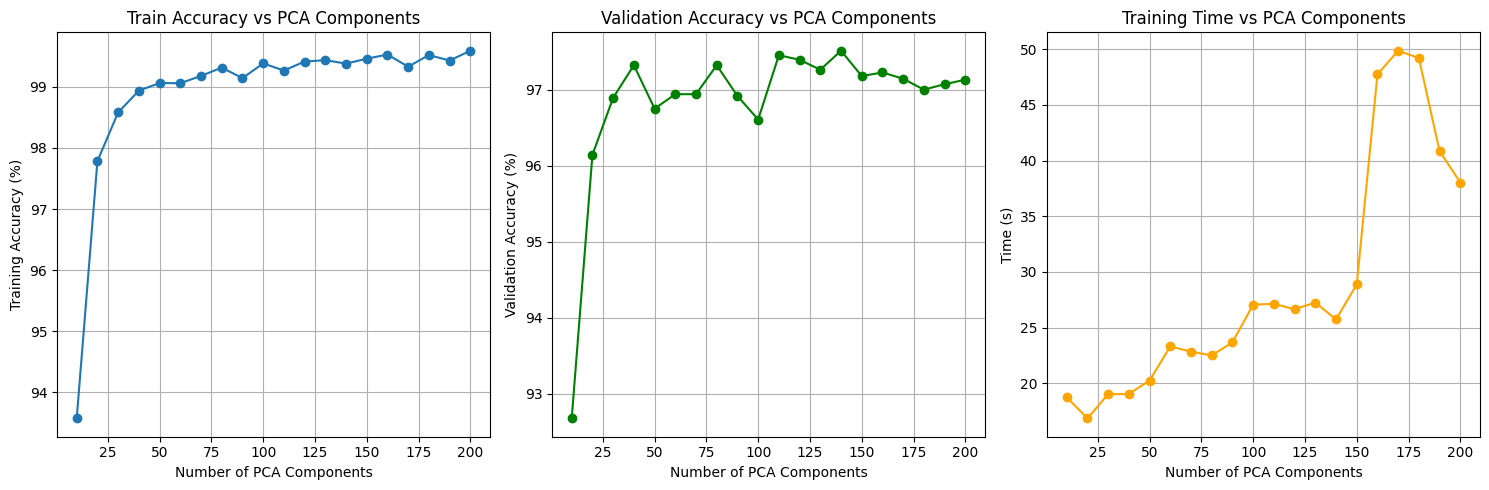

In [49]:
plt.figure(figsize=(15, 5))

# Plot training accuracy
plt.subplot(1, 3, 1)
plt.plot(results_df["Components"], results_df["Train_Accuracy"], marker='o', label='Train Accuracy')
plt.title("Train Accuracy vs PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("Training Accuracy (%)")
plt.grid(True)

# Plot validation accuracy
plt.subplot(1, 3, 2)
plt.plot(results_df["Components"], results_df["Val_Accuracy"], marker='o', color='green', label='Validation Accuracy')
plt.title("Validation Accuracy vs PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("Validation Accuracy (%)")
plt.grid(True)

# Plot training time
plt.subplot(1, 3, 3)
plt.plot(results_df["Components"], results_df["Time"], marker='o', color='orange', label='Training Time')
plt.title("Training Time vs PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("Time (s)")
plt.grid(True)

plt.tight_layout()
plt.show()